In [1]:
import diplib as dip
import random
import numpy as np

DIPlib -- a quantitative image analysis library
Version 3.5.1 (Jul  5 2024)
For more information see https://diplib.org


In [2]:
def generate_image(overlap):
    sd = 0.001
    sz = 5.0
    scale = sz*sz*2*3.14159
    channel1 = dip.Image([256, 256], 1, 'SFLOAT')
    channel2 = dip.Image([256, 256], 1, 'SFLOAT')
    channel1.Fill(0)
    channel2.Fill(0)
    for jj in range(8):
        for ii in range(8):
            x = 4 * sz + ii * 6 * sz
            y = 4 * sz + jj * 6 * sz
            dip.DrawBandlimitedPoint(channel1, [x, y], scale, sz)   # 以高斯斑点的形式绘制点 scale是高斯函数的标准差 sz是斑点的半径
            if ii < 6:
                if jj * 8 + ii > 8 * 8 * overlap:
                    x += 3 * sz
                    y += 1 * sz
                dip.DrawBandlimitedPoint(channel2, [x, y], [scale], [sz])
    channel1 = dip.ClipLow(dip.GaussianNoise(channel1, sd**2), low=0)   # 添加高斯噪声 ClipLow函数将图像中的负值像素设置为0 ClipLow 将小于low的值设置为low 也就是将负值设置为0
    channel2 = dip.ClipLow(dip.GaussianNoise(channel2, sd**2), 0)
    return channel1, channel2


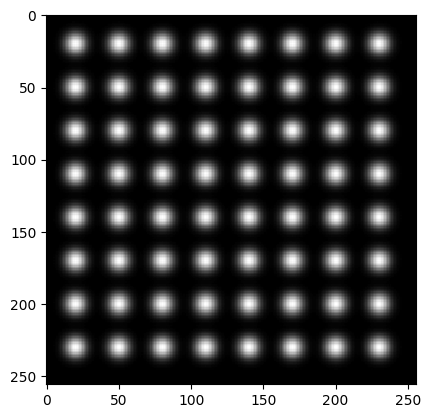

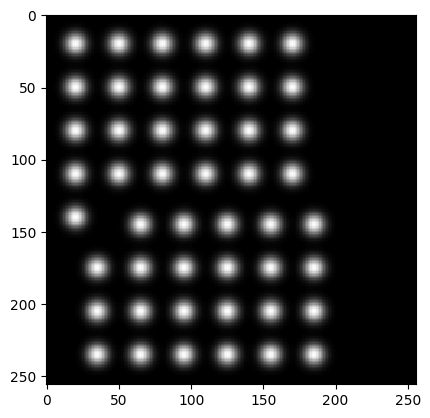

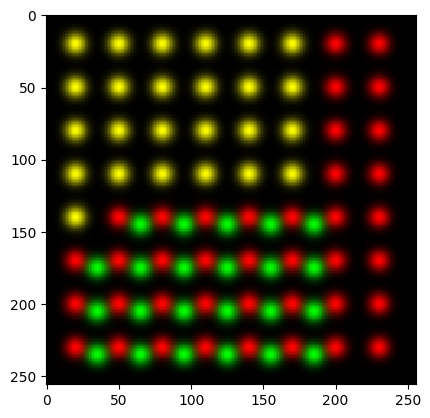

In [5]:
channel1, channel2 = generate_image(0.5)
channel1.Show()
channel2.Show()
channel12 = dip.JoinChannels([channel1, channel2])  # 将两个单通道图像合并为一个多通道图像
dip.JoinChannels([channel1, channel2]).Show()

In [8]:
for overlap in [0.1, 0.3, 0.5, 0.7, 0.9]:
    channel1, channel2 = generate_image(overlap)
    print()
    print('# Overlap: ', overlap)
    coef = dip.PearsonCorrelation(channel1, channel2)   # 计算两个图像的皮尔逊相关系数
    print('Pearson correlation coefficient: ', round(coef, 3))
    coef = dip.MandersOverlapCoefficient(channel1, channel2)   # 计算两个图像的Manders重叠系数
    print('Manders overlap coefficient: ', round(coef, 3))
    coef = dip.IntensityCorrelationQuotient(channel1, channel2)   # 计算两个图像的强度相关系数
    print('Intensity correlation quotient: ', round(coef, 3))
    coef = dip.MandersColocalizationCoefficients(channel1, channel2, None, 0.2, 0.2)    # 计算两个图像的Manders共定位系数
    print('Manders colocalization coefficients: ', round(coef[0], 3), round(coef[1], 3))
    coef = dip.CostesColocalizationCoefficients(channel1, channel2)  # 计算两个图像的Costes共定位系数
    print('Costes colocalization coefficients: ', round(coef[0], 3), round(coef[1], 3))



# Overlap:  0.1
Pearson correlation coefficient:  -0.046
Manders overlap coefficient:  0.23
Intensity correlation quotient:  0.11
Manders colocalization coefficients:  0.146 0.195
Costes colocalization coefficients:  0.0 0.0

# Overlap:  0.3
Pearson correlation coefficient:  0.161
Manders overlap coefficient:  0.382
Intensity correlation quotient:  0.177
Manders colocalization coefficients:  0.254 0.338
Costes colocalization coefficients:  0.089 0.118

# Overlap:  0.5
Pearson correlation coefficient:  0.347
Manders overlap coefficient:  0.518
Intensity correlation quotient:  0.238
Manders colocalization coefficients:  0.351 0.467
Costes colocalization coefficients:  0.228 0.304

# Overlap:  0.7
Pearson correlation coefficient:  0.553
Manders overlap coefficient:  0.669
Intensity correlation quotient:  0.305
Manders colocalization coefficients:  0.458 0.61
Costes colocalization coefficients:  0.415 0.55

# Overlap:  0.9
Pearson correlation coefficient:  0.74
Manders overlap coefficient

为了应用Costes的显著性检验，我们需要估计自相关函数的宽度

In [9]:
ac = dip.AutoCorrelationFT(channel1)    # 使用傅里叶变换计算自相关函数
ac = ac > dip.Maximum(ac)[0][0] / 2  # half maximum # 将自相关函数的值大于最大值的一半的像素设置为1，其余设置为0 用于计算自相关函数的宽度
ac = dip.Label(ac)  # 标记连通区域    也就是说一组连通的1被标记为一个区域
cc = dip.GetImageChainCodes(ac, ac[ac.Size(0)//2, ac.Size(1)//2]) # find central blob # 获取图像的链码 也就是获取图像的轮廓
bb = cc[0].BoundingBox()    # 获取轮廓的外接矩形
blockSizes = [bb[1][0] - bb[0][0], bb[1][1] - bb[0][1]] # width and height, corresponds to full width at half maximum   # 计算外接矩形的宽度和高度
print(blockSizes)   # 输出宽度和高度

[16, 16]


使用该宽度作为Costes显著性检验的参数

In [10]:
for overlap in [0.00, 0.14, 0.16, 0.18, 0.20, 0.22]:
    channel1, channel2 = generate_image(overlap)
    print(overlap, round(dip.CostesSignificanceTest(channel1, channel2, None, blockSizes, 500), 4))

0.0 0.0
0.14 0.0471
0.16 0.8662
0.18 0.9869
0.2 0.9998
0.22 1.0
